<a href="https://colab.research.google.com/github/youkjang/Climate_Chage/blob/main/Threshold_Analysis_ExtremeHeat_MD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Maryland Maximum Temperature Threshold Analysis

- LOCA CMIP6 daily maximum temperature for Maryland
- Counts of how many days/year exceed a critical maximum temperature threshold (> 35°C)
- Compute and plot annual mean for extreme heat (time series)
- Spatial map of Extreme Heat Days for some years



###Reference
- https://loca.ucsd.edu/loca-version-2-for-north-america-ca-jan-2023/
- shapefile for MD (MDOT SHA County Boundaries data): https://data.imap.maryland.gov/



In [1]:
!pip install cartopy --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 111.5 MB/s eta 0:00:00


In [2]:
!pip install us --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.9/356.9 kB 18.7 MB/s eta 0:00:00


In [3]:
import geopandas as gpd
import us

In [4]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

###Load historical & future daily maximum temperature

In [5]:
filename = 'tasmax.GFDL-CM4.historical.MD.nc'
filename1 = 'tasmax.GFDL-CM4.ssp245.MD.nc'
filename2 = 'tasmax.GFDL-CM4.ssp585.MD.nc'

In [6]:
ds = xr.open_dataset(filename)

In [34]:
ssp245 = xr.open_dataset(filename1)

In [35]:
ssp585 = xr.open_dataset(filename2)

In [36]:
ds1 = xr.concat([ds, ssp245],dim='time')
ds2 = xr.concat([ds, ssp585],dim='time')

###Load and transform spatial data
- Convert the coordinates of the county boundaries into the standard latitude and longitude system

In [10]:
gdf = gpd.read_file('MDOT_SHA_County_Boundaries.zip')
gdf = gdf.to_crs("EPSG:4326")

In [11]:
ds

<xarray.Dataset> Size: 228MB
Dimensions:  (time: 23741, lat: 30, lon: 80)
Coordinates:
  * time     (time) datetime64[ns] 190kB 1950-01-01T12:00:00 ... 2014-12-31T1...
  * lon      (lon) float64 640B 280.0 280.1 280.2 280.2 ... 284.8 284.9 285.0
  * lat      (lat) float64 240B 38.16 38.22 38.28 38.34 ... 39.84 39.91 39.97
Data variables:
    tasmax   (time, lat, lon) float32 228MB ...

### Apply Heat Threshold: 35°C

In [40]:
threshold = 35
extreme_heat = ds > threshold
extreme_heat1 = ds1 > threshold
extreme_heat2 = ds2 > threshold

###Count Extreme Heat Days per Year

In [63]:
extreme_heat_annual = extreme_heat.groupby('time.year').sum(dim='time')
extreme_heat_annual1 = extreme_heat1.groupby('time.year').sum(dim='time')
extreme_heat_annual2 = extreme_heat2.groupby('time.year').sum(dim='time')

###Plot Time Series of Spatial Average

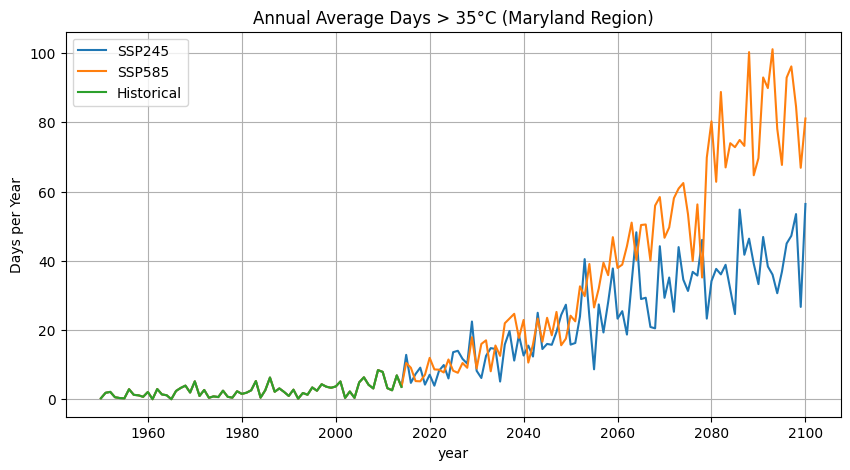

In [44]:
regional_avg = extreme_heat_annual['tasmax'].mean(dim=['lat', 'lon'])
regional_avg1 = extreme_heat_annual1['tasmax'].mean(dim=['lat', 'lon'])
regional_avg2 = extreme_heat_annual2['tasmax'].mean(dim=['lat', 'lon'])


plt.figure(figsize=(10, 5))
regional_avg1.plot(label='SSP245')
regional_avg2.plot(label='SSP585')
regional_avg.plot(label='Historical')
plt.legend()
plt.title(f"Annual Average Days > {threshold}°C (Maryland Region)")
plt.ylabel("Days per Year")
plt.grid(True)
plt.show()


###Plot Saptial Map for One Year

In [78]:
def plot_threshold_map(year,ssp):
  fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

  year_to_plot = year
  if ssp == 'Historical':
    data_to_plot = extreme_heat_annual
  elif ssp == 'SSP245':
    data_to_plot = extreme_heat_annual1
  elif ssp == 'SSP585':
    data_to_plot = extreme_heat_annual2

  data_to_plot['tasmax'].sel(year=year_to_plot).plot(
      cmap='Reds', levels=30, vmin=0, vmax=60,
      cbar_kwargs={'label': f'Days > {threshold}°C'}
  )

  # Plot shapefile on top
  gdf.boundary.plot(ax=ax, edgecolor='black', linewidth=1)
  # Add text labels from the 'COUNTY' column
  for i, row in gdf.iterrows():
      x, y = row.geometry.centroid.x, row.geometry.centroid.y  # Use centroid for better placement
      name = row['COUNTY']  # Replace 'COUNTY' if your name column is different
      ax.text(x, y, name, fontsize=8, ha='center', va='center') #Center the text

  #ax.coastlines()
  ax.add_feature(cfeature.BORDERS, linestyle=':')


  plt.title(ssp+f"   Extreme Heat Days in {year_to_plot}")
  plt.show()

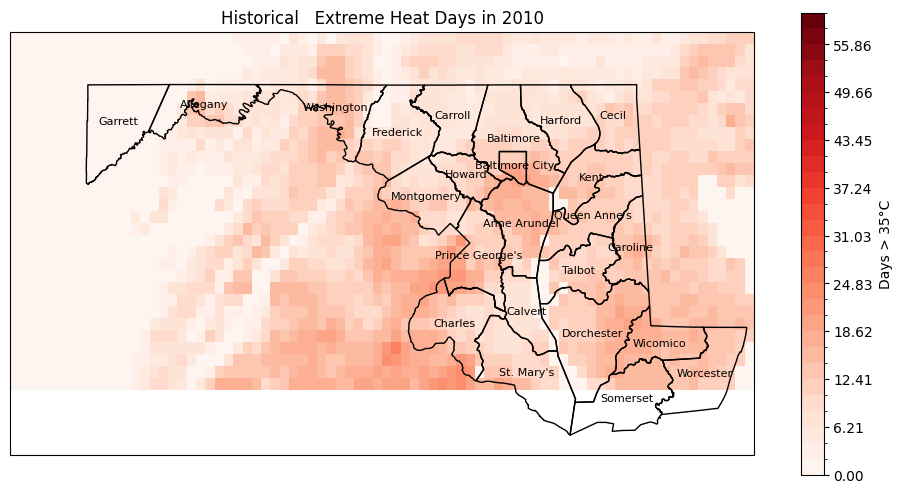

In [79]:
plot_threshold_map(2010,'Historical')

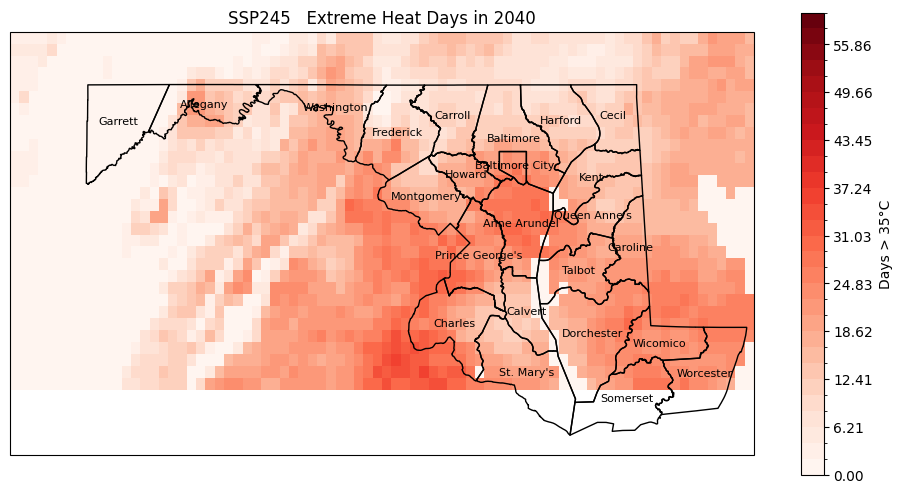

In [80]:
plot_threshold_map(2040,'SSP245')

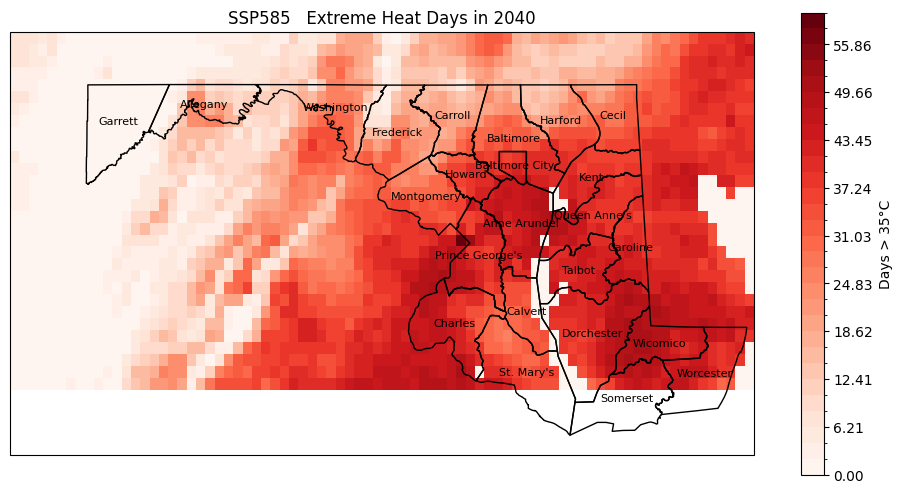

In [81]:
plot_threshold_map(2040,'SSP585')